# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IIC2440 - Procesamiento de Datos Masivos
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2024-1**<br>
**Profesor:** Juan Reutter, Adrián Soto <br>
**Integrantes:** David Ortega, Bastian Baez Oses <br>





---

# Bullet 1

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Conexión a Neo4j
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "12345678")

# Función pedida
def get_nodes_and_relationships(uri, auth):
    driver = GraphDatabase.driver(uri, auth=auth)
    nodes = []
    relationships = []

    def fetch_graph(tx):
        result = tx.run("MATCH (n)-[r:TICKET]->(m) RETURN id(n) AS from, id(m) AS to, r.type AS type")
        for record in result:
            relationships.append((record["from"], record["type"], record["to"]))

    with driver.session() as session:
        session.read_transaction(fetch_graph)

    driver.close()
    return relationships

# Obtener nodos y relaciones de Neo4j
relationships = get_nodes_and_relationships(URI, AUTH)
print("Relaciones en Neo4j:\n", relationships)

# relationships son las relaciones para cargar en el pyspark. El output seria
# el siguiente:


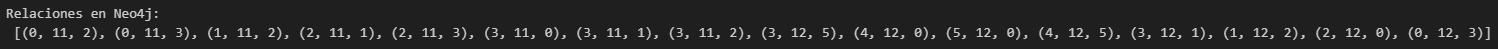

## Definiciones grafos

In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession
import numpy as np
from itertools import combinations

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc

# Datos de prueba
edges = [
    (0,11,2),
    (0,11,3),
    (1,11,2),
    (2,11,1),
    (2,11,3),
    (3,11,0),
    (3,11,1),
    (3,11,2),
    (3,12,5),
    (4,12,0),
    (5,12,0),
    (4,12,5),
    (3,12,1),
    (1,12,2),
    (2,12,0),
    (0,12,3),
    ]

# Crear la RDD
rdd = sc.parallelize(edges)

## Bullet 2


In [ ]:
# Parámetro b
b = 5

# Función hash
def hash_function(node, b):
    return node % b

# Función de map
def mapfunc(arista, b):
  n1, etiqueta, n2 = arista
  b1 = hash_function(n1, b)
  b2 = hash_function(n2, b)
  results = []
  for i in range(b):
    key = (b1, b2, i)
    results.append((key, arista))
    key =  (i, b1, b2)
    results.append((key, arista))
    key = (b2, i, b1)
    results.append((key, arista))
  return results


# Fase de Reduce
def reduce_function(key, values):
    edges = list(values)
    triangles = []
    for (n1, R1, n2) in edges:
        for (n2_, R2, n3) in edges:
            if n2 == n2_:
                for (n3_, R3, n1_) in edges:
                    if n3 == n3_ and n1 == n1_:
                        triangles.append((n1, n2, n3))
    return triangles




# Aplicar el algoritmo
triangulos = set(rdd.flatMap(lambda x: mapfunc(x, 5)).groupByKey().flatMap(lambda x: reduce_function(x[0], x[1])).collect())

print("Triangulos")
if len(triangulos)>0:
  for triangulo in triangulos:
    print(triangulo)
else:
  print("No se encontraron triangulos")




Triangulos
(3, 2, 0)
(3, 5, 0)
(1, 2, 3)
(0, 2, 3)
(3, 0, 2)
(3, 1, 2)
(2, 3, 1)
(5, 0, 3)
(0, 3, 5)
(2, 0, 3)
(0, 3, 2)
(2, 3, 0)


# Bullet 4

In [ ]:
# Parámetro b
b = 5

# Fase de Map
def map_function(arista, b):
    n1, etiqueta, n2 = arista
    b1 = hash_function(n1, b)
    b2 = hash_function(n2, b)
    results = []
    for i in range(b):
        for j in range(b):
            key = (b1, b2, i, j)
            results.append((key, arista))
            key = (b1, i, b2, j)
            results.append((key, arista))
            key = (b1, i, j, b2)
            results.append((key, arista))
            key = (i, b1, b2, j)
            results.append((key, arista))
            key = (i, b1, j, b2)
            results.append((key, arista))
            key = (b2, b1, i, j)
            results.append((key, arista))
            key = (i, j, b1, b2)
            results.append((key, arista))
            key = (b2, j, b1, i)
            results.append((key, arista))
            key = (i, b2, b1, j)
            results.append((key, arista))
            key = (b2, i, j, b1)
            results.append((key, arista))
            key = (i, b2, j, b1)
            results.append((key, arista))
            key = (i, j, b2, b1)
            results.append((key, arista))
    return results

def encontrar_patrones(grafo, patron):
    resultados = []
    m = len(patron)
    grafo = list(grafo)
    grafo.sort(key=lambda x: (x[0], x[2]))
    grafo.sort(key=lambda x: x[1])

    # Función auxiliar para verificar si una subsecuencia del grafo coincide con el patrón
    def coincide_subsecuencia(subgrafo, patron):
        asignacion = {}
        for (nodo1, etiqueta1, nodo2), (nodo_patron1, etiqueta_patron, nodo_patron2) in zip(subgrafo, patron):

            if etiqueta1 != etiqueta_patron:
                return False
            if nodo_patron1 not in asignacion:
                if nodo1 in asignacion.values():
                  return False
                asignacion[nodo_patron1] = nodo1
            elif asignacion[nodo_patron1] != nodo1:
                return False
            if nodo_patron2 not in asignacion:
              if nodo2 in asignacion.values():
                  return False
              asignacion[nodo_patron2] = nodo2
            elif asignacion[nodo_patron2] != nodo2:
                return False
        return True

    # Generar todas las combinaciones posibles de aristas del grafo de longitud igual al patrón
    for subgrafo in combinations(grafo, m):
        if coincide_subsecuencia(subgrafo, patron):
            resultados.append(subgrafo)

    return resultados


# Función para convertir la matriz M a una lista de tuplas (nodo_x, arista, nodo_y)
def convert_matrix_to_edge_list(A, L, M):
    edge_list = []
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(len(L)):
                if M[i][k][j] == 1:
                    edge_list.append((i, L[k], j))
    return edge_list


def bullet_4(A, L, M, b):
  patron = convert_matrix_to_edge_list(A,L,M)
  patron.sort(key=lambda x: (x[0], x[2]))
  patron.sort(key=lambda x: x[1])
  mapeado = rdd.flatMap(lambda edge: map_function(edge, b))
  retorno = set(mapeado.groupByKey().flatMap(lambda x: encontrar_patrones(x[1], patron)).collect())
  if len(retorno) > 0:
    print("El patron se encontró en:")
    for p in retorno:
      print(p)
  else:
    print("No se encontró el patron en el grafo")


## TESTEO

In [ ]:
# Nodos y tipos de aristas
A = ["x", "y", "z", "w"]
L = [11, 12]

# Ejemplo de aristas
edges_patron = [
    (0,0,2), # ("x", "11", "z")
    (0,0,3), # ("x", "11", "w")
    (1,0,2), # ("y", "11", "z")
    (2,0,1), # ("z", "11", "y")
    (2,0,3), # ("w", "11", "z")
    (3,0,0), # ("w", "11", "x")
    (1,1,2), # ("y", "12", "z")
    (2,1,0), # ("z", "12", "x")
]

# Inicializar la matriz M con ceros
num_nodes = len(A)
num_edges = len(L)
M = np.zeros((num_nodes, num_edges, num_nodes), dtype=int)

# Llenar la matriz M con las aristas
for x, r, y in edges_patron:
  M[x][r][y] = 1

# Convertir la matriz NumPy a una lista de listas
M = M.tolist()

print("Matriz:", M)

Matriz: [[[0, 0, 1, 1], [0, 0, 0, 0]], [[0, 0, 1, 0], [0, 0, 1, 0]], [[0, 1, 0, 1], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 0]]]


In [ ]:
bullet_4(A,L,M,b)

El patron se encontró en:
((0, 11, 2), (0, 11, 3), (1, 11, 2), (2, 11, 1), (2, 11, 3), (3, 11, 0), (1, 12, 2), (2, 12, 0))


In [ ]:
# Nodos y tipos de aristas
A = ["x", "y", "z", "w"]
L = [11, 12, 13]

# Ejemplo de aristas
edges_patron = [
    (0,2,2)
]

# Inicializar la matriz M con ceros
num_nodes = len(A)
num_edges = len(L)
M = np.zeros((num_nodes, num_edges, num_nodes), dtype=int)

# Llenar la matriz M con las aristas
for x, r, y in edges_patron:
  M[x][r][y] = 1

# Convertir la matriz NumPy a una lista de listas
M = M.tolist()

bullet_4(A,L,M,b)

No se encontró el patron en el grafo


In [ ]:
# Nodos y tipos de aristas
A = ["x", "y", "z", "w"]
L = [11, 12, 13]

# Ejemplo de aristas
edges_patron = [
    (0,0,1),
    (1,0,2),
    (2,1,3),
    (3,1,0)
]

# Inicializar la matriz M con ceros
num_nodes = len(A)
num_edges = len(L)
M = np.zeros((num_nodes, num_edges, num_nodes), dtype=int)

# Llenar la matriz M con las aristas
for x, r, y in edges_patron:
  M[x][r][y] = 1

# Convertir la matriz NumPy a una lista de listas
M = M.tolist()

bullet_4(A,L,M,b)

El patron se encontró en:
((0, 11, 2), (2, 11, 3), (3, 12, 5), (5, 12, 0))
((0, 11, 3), (3, 11, 1), (1, 12, 2), (2, 12, 0))
